# Connect to GDrive and set working directory
## !! Skip if you run in local !!
1. Add a shortcut for working directory('IDPCode') to your drive as depicted below:
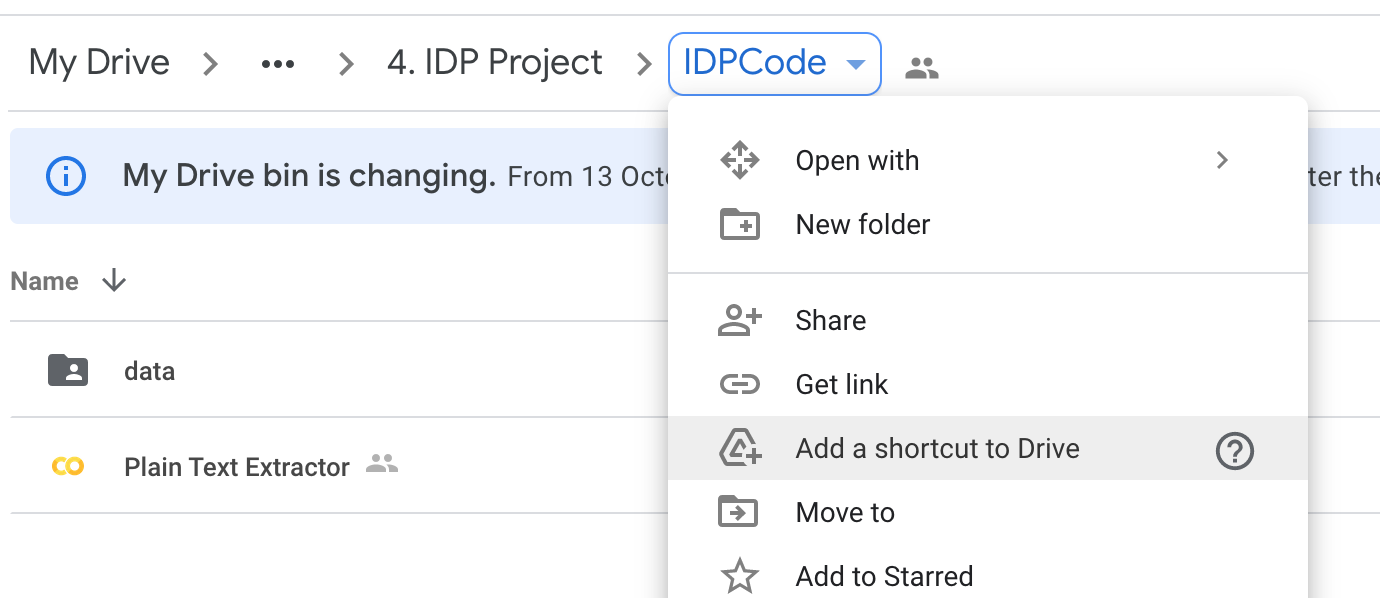
2. Run the command below to connect the GDrive:



In [ ]:
# https://github.com/njanakiev/folderstats
# https://janakiev.com/blog/python-filesystem-analysis/
# https://networkx.org/documentation/stable/
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/IDPCode/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1d2RlPHkcJvE2Q0NDVZjeNW8VcVz3h_WL/IDPCode


In [ ]:
norms     = pickle.load( open( "model/model__norms.pkl", "rb" ) )

time: 346 ms (started: 2021-04-09 11:10:22 +00:00)


In [ ]:
type(norms)

numpy.ndarray

time: 4.51 ms (started: 2021-04-09 11:11:21 +00:00)


In [ ]:
!pip install ipython-autotime
!pip install pickle5
!pip install spacy
!pip install spacy_langdetect
!pip install textacy
!pip install pandarallel

     |████████████████████████████████| 133kB 14.6MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219245 sha256=e82f66c0b3def8b6451d5d578e91a15ccd7179320b3c9fcaff6d47a8395e8a39
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5
     |████████████████████████████████| 1.0MB 24.6MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-cp37-none-any.whl size=993460 sha256=255d5871d938b882fecd92f84bb451a67d39216643f5835ab2792ed8148ad1bf
  Stored in directory: /root/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
Successfully built langdetect
     |████████████████████████████████| 184kB 16.8MB/s 
     |████████████████████████████████| 92kB 9.2MB/s 
     |████████████████████████████████| 481kB 50.0MB/s 
     |████████████████████████████████| 1.9MB 50.0MB/s 
  Created wheel for cytoolz: filename=cytoolz-0.11.0-cp37-cp37m-linux_

In [ ]:
import pandas as pd
import numpy as np
import pickle5 as pickle
import pickle as normal_pickle
import gensim

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# show execution time of cells
%load_ext autotime

# CHANGE PATH FOR THE DATASET FOLDER
DATA_DIRECTORY='data'


time: 167 µs (started: 2021-04-09 11:10:22 +00:00)


In [ ]:
REPLACED_WORDS_EXCEL = pd.read_excel(DATA_DIRECTORY+'/StopWords/removed_words.xlsx')
REPLACED_WORDS = REPLACED_WORDS_EXCEL[REPLACED_WORDS_EXCEL['Reasonable?']==True]
REPLACED_WORDS.head(10)
print(f'Number of words: {len(REPLACED_WORDS_EXCEL)}')
print(f'Number of approved words: {len(REPLACED_WORDS)}')
REPLACED_WORDS.head(10)
REPLACED_WORDS = REPLACED_WORDS['Removed Words'].values
print(REPLACED_WORDS)

In [ ]:
import en_core_web_sm
nlp = en_core_web_sm.load()
#https://pypi.org/project/spacy-langdetect/
from spacy_langdetect import LanguageDetector
nlp.add_pipe(LanguageDetector(), name="language_detector", last=True)

time: 1.68 s (started: 2021-02-19 14:40:18 +00:00)


In [ ]:
# Utility functions
def remove_dollar_sign(text):
  '''
  While drawing title count distribution, mathplotlib throws an error.
  Because some titles have dollar sign('$'). This method is used to clear the sign.
  '''
  
  text = str(text).replace('$', '\$')
  return text

import re
import string
import textacy
from textacy import preprocessing
def clean_text(text):
  '''
  Eliminates links, non alphanumerics, and punctuation.
  Returns lower case text.
  '''  
  
  # Convert to string
  text = str(text)
  # Remove non-ascii
  text = text.encode('ascii', 'ignore').decode('ascii')
  # Remove links
  text = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', '', text)
  # Remove E-Mail addresses
  text = re.sub(r'\b[a-z]+@[a-z]+\b', r'', str(text))
  # Remove non-alphanumerics
  text = re.sub('\w*\d\w*', ' ', text)
  # Remove punctuation and lowercase
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text.lower())
  # Remove newline characters
  text = re.sub("\n", r' ', text)
  # Remove text in square brackets
  text = re.sub(r'\[.*?\]', '', text)
  # Remove words containing numbers
  text = re.sub(r'\w*\d\w*', '', text)
  # https://textacy.readthedocs.io/en/0.10.1/_modules/textacy/preprocessing/normalize.html
  text = textacy.preprocessing.normalize.normalize_whitespace(str(text))
  # replace words with less than 2 characters
  text = re.sub(r'\b[a-z]{1,2}\b', r'', str(text))
    
  return text

def replace_text(text, replacement_texts=REPLACED_WORDS):
  pattern = re.compile("|".join([re.escape(i) for i in replacement_texts]))
  text = pattern.sub(lambda m: '', str(text))
  return text

def lemmatizer(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):        
  sent = []
  doc = nlp(text)
#  for word in doc:
#    sent.append(word.lemma_)
  sent =  [token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]
    
  return " ".join(sent)

# Lemmatization, remove pronouns.
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        texts_out.append(lemmatizer(" ".join(sent), allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']))
    return texts_out

def remove_stopwords(text):
  clean_text = []
  for word in text.split(' '):
    if word not in stop_list and (len(word) > 2):
      clean_text.append(word)
  
  return ' '.join(clean_text)

def display_topics(model, feature_names, no_top_words, no_top_topics, topic_names=None):
  count = 0
  for ix, topic in enumerate(model.components_):
    if count == no_top_topics:
      break
    if not topic_names or not topic_names[ix]:
      print("\nTopic ", (ix + 1))
    else:
      print("\nTopic: '",topic_names[ix],"'")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]]))
    count += 1
    
def word_count(text):
    return sum([i.strip(string.punctuation).isalpha() for i in text.split()])
  
from IPython.core.display import display, HTML
def print_html(data):
  display(HTML('<div style="width: 90%">'+data+'</div>'))
  
  
def print_lemmatized(text, colorized_ignored=False, ignore_type='allowed'):
  allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
  doc_lemma = nlp(text)
  lemms = []
  poses = []
  #colors = ['#f88f88','#DA553F','#045E5B','#731425','#F61E9E','#f44f44','#ff0','#0ff','#f0f']  
  import random
  r = lambda: random.randint(0,255)
  colors = ['#%02X%02X%02X' % (r(),r(),r()) for i in range(30)]

  for token in doc_lemma:
    if token.pos_ not in poses:
      poses.append(token.pos_)

  print(poses)
  for token in doc_lemma:
    if (ignore_type=='allowed' and token.pos_ not in allowed_postags) or (ignore_type=='stop_word' and token.is_stop):
      ignored_color = '#FF8983' if colorized_ignored else colors[poses.index(token.pos_)]
      
      lemms.append('<span style="color: #fff; padding: 0 10px; background-color: '+ignored_color+'"> '+token.lemma_+' </span>')
    else:
      lemms.append(token.lemma_)
      
  print_html('allowed_postags: '+' '.join(['<span style="color: #fff; padding: 0 10px; background-color: '+colors[allowed_postags.index(i)]+'"> '+i+' </span>' for i in allowed_postags]))
  print_html('available: '+' '.join(['<span style="color: #fff; padding: 0 10px; background-color: '+colors[poses.index(i)]+'"> '+i+' </span>' for i in poses]))
  print_html(' '.join(lemms))
  
import os
def get_file_name(file_path):
  f = os.path.basename(file_path)
  return f.replace('.pdf', '')

def run_in_parallel(dt, function, n_cores=8):
    df_n = np.array_split(df, n_cores)

    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_n))
    pool.close()
    pool.join()
    return df
  
def remove_non_english_sent(text):
  doc = nlp(text)
  return ' '.join([sent.text for sent in doc.sents if sent._.language["language"] == 'en'])

def document_lang(text):
  doc = nlp(text)
  return doc._.language["language"]

def combine_authors(author_list):
  if isinstance(author_list, list):
    return ', '.join(author_list)

  return author_list

def journal_name(text):
  text = get_file_name(text)
  t = re.findall('([0-9]+)_([a-zA-Z]+)', text, re.IGNORECASE)
  return [i[1] for i in t][0]

from sklearn.metrics.pairwise import cosine_similarity

def produce_rec_top_n(top_vec, topic_array, doc_topic_df, norms, n=5):
    co_dists = compute_dists(top_vec, topic_array, norms)
    index_top_n = np.argpartition(co_dists, -n)[-n:]
    index_top_n = index_top_n[np.argsort(-co_dists[index_top_n])]
    return doc_topic_df.loc[index_top_n]
  
def compute_dists(top_vec, topic_array, norms):
    '''
    Returns cosine distances for top_vec compared to every article
    '''
    dots = np.matmul(topic_array, top_vec)
    input_norm = np.linalg.norm(top_vec)
    co_dists = dots / (input_norm * norms)
    return co_dists
  
def produce_rec(top_vec, topic_array, doc_topic_df, norms, rand = 15):
    '''
    Produces a recommendation based on cosine distance.
    rand controls magnitude of randomness.
    '''
#    top_vec = top_vec + np.random.rand(30,)/(np.linalg.norm(top_vec)) * rand
    co_dists = compute_dists(top_vec, topic_array, norms)
    return doc_topic_df.loc[np.argmax(co_dists)]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Define function to predict topic for a given new question.
def predict_topic(text, lda_model, count_vectorizer, df_topic_keywords, nlp=nlp):
    global sent_to_words

    # Clean
    for i in range(len(text)):
      text[i] = clean_text(text[i])
      
    #
    for i in range(len(text)):
      text[i] = replace_text(text[i])
    for i in range(len(text)):
      text[i] = clean_text(text[i])
      
    # Remove stopwords
    for i in range(len(text)):
      text[i] = remove_stopwords(text[i])
    
    # Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Lemmatize is skipped !!!
    # mytext_3_1 = []
    # for sent in mytext_2:
    #   mytext_3_1.append(" ".join(sent))
    # Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    #print('Text after lemmatization ({} characters):'.format(len(mytext_3[0])))
    #print(mytext_3[0][0:100]+" ...")
    
    # stemming is skipped !!!
    #mytext_3_1 = []
    #for t in mytext_3:
    #  mytext_3_1.append(stem_text(t))
    
    # Vectorize transform
    mytext_4 = count_vectorizer.transform(mytext_3)
    
    #print('Count vectorizer of transformed text: {}'.format(mytext_4.shape))
    #print('Vectorized data {}'.format(data_vectorized.shape))
    #print('First 100 Feature names:')
    #print(count_vectorizer.get_feature_names()[:100])
    #print('')
    

    # LDA Transform
    topic_probability_scores = lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores
  

def accuracy_n(file_path, data, lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n=[1]):
  #print(file_path)
  topic, prob_scores = predict_topic([data], lda_model, count_vectorizer, df_topic_keywords)

  topic_columns = ['Topic '+str(i) for i in range(1, df_topic_keywords.shape[0]+1)]
  recs = produce_rec_top_n(prob_scores.flatten(), topic_array, doc_topic_df, norms, max(top_n))

  existence = []
  
  for n in top_n:    
    if recs['file_path'].head(n).str.contains(get_file_name(file_path)).any():
      existence.append(1)
    else:
      existence.append(0)

  return pd.Series(existence)


def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
  
def label_theme(row):
    return "Topic " + str(row)

  
  


time: 1.76 s (started: 2021-02-19 14:40:20 +00:00)


In [ ]:
dt = pickle.load(open('en_cleaned_accounting_replaced_stop_words_lemmatized_all_pages_separetely.pkl', "rb"))# https://drive.google.com/file/d/11ZYfDF9XSXY5bHVhpEHeZXInnNIa9lot/view?usp=sharing

time: 2min 11s (started: 2021-02-11 22:01:23 +00:00)


In [ ]:
rt = pd.read_excel('DATA_RELEVANT.xlsx')

time: 13.4 s (started: 2021-02-19 14:40:22 +00:00)


In [ ]:
# Import
from pandarallel import pandarallel

# Initialization
pandarallel.initialize()

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time: 20.9 ms (started: 2021-02-19 14:40:22 +00:00)


In [ ]:
col_page = [col for col in dt if col.startswith('page') and not col.endswith('_wc')]
col_page_wc = [col for col in dt if col.startswith('page') and col.endswith('_wc')]

### 1.3.1 Find accounting related stop words

from https://sraf.nd.edu/textual-analysis/resources/

In [ ]:
stop_words_data1 = open(DATA_DIRECTORY + "/StopWords/StopWords_Auditor.txt", "r").read().lower().split()
stop_words_data2 = open(DATA_DIRECTORY + "/StopWords/StopWords_Currencies.txt", "r").read().lower().split()
stop_words_data3 = open(DATA_DIRECTORY + "/StopWords/StopWords_DatesandNumbers.txt").read().lower().split()
stop_words_data4 = open(DATA_DIRECTORY + "/StopWords/StopWords_Generic.txt").read().lower().split()
stop_words_data5 = open(DATA_DIRECTORY + "/StopWords/StopWords_GenericLong.txt").read().lower().split()
stop_words_data6 = open(DATA_DIRECTORY + "/StopWords/StopWords_Geographic.txt").read().lower().split()
stop_words_data7 = open(DATA_DIRECTORY + "/StopWords/StopWords_Names.txt").read().lower().split()

mallet_stop_words_en = open(DATA_DIRECTORY + "/StopWords/MALLET_en.txt", "r").read().lower().split()
mallet_stop_words_fr = open(DATA_DIRECTORY + "/StopWords/MALLET_fr.txt", "r").read().lower().split()

stop_words_data2 = list(filter(lambda a : a != "|", stop_words_data2))
stop_words_data3 = list(filter(lambda a : a != "|", stop_words_data3))
stop_words_data6 = list(filter(lambda a : a != "|", stop_words_data6))
stop_words_data7 = list(filter(lambda a : a != "|", stop_words_data7))

stop_words_data = stop_words_data1 + \
stop_words_data2 + \
stop_words_data3 + \
stop_words_data4 + \
stop_words_data5 + \
stop_words_data6 + \
stop_words_data7 + \
mallet_stop_words_en + \
mallet_stop_words_fr

print(f'{len(set(stop_words_data1))} => StopWords_Auditor.txt')
print(f'{len(set(stop_words_data2))} => StopWords_Currencies.txt')
print(f'{len(set(stop_words_data3))} => StopWords_DatesandNumbers.txt')
print(f'{len(set(stop_words_data4))} => StopWords_Generic.txt')
print(f'{len(set(stop_words_data5))} => StopWords_GenericLong.txt')
print(f'{len(set(stop_words_data6))} => StopWords_Geographic.txt')
print(f'{len(set(stop_words_data7))} => StopWords_Names.txt')
print(f'{len(set(mallet_stop_words_en))} => MALLET English Stopwords')
print(f'{len(set(mallet_stop_words_fr))} => MALLET French Stopwords')

print(f'StopWords_Auditor.txt {len(stop_words_data1)}' + \
'StopWords_Currencies.txt {len(stop_words_data2)}' + \
'StopWords_DatesandNumbers.txt {len(stop_words_data3)}' + \
'StopWords_Generic.txt {len(stop_words_data4)}' + \
'StopWords_GenericLong.txt {len(stop_words_data5)}' + \
'StopWords_Geographic.txt {len(stop_words_data6)}' + \
'StopWords_Names.txt {len(stop_words_data7)}')
print(f'MALLET_en.txt {len(mallet_stop_words_en)}')
print(f'MALLET_fr.txt {len(mallet_stop_words_fr)}')

8 => StopWords_Auditor.txt
186 => StopWords_Currencies.txt
115 => StopWords_DatesandNumbers.txt
121 => StopWords_Generic.txt
570 => StopWords_GenericLong.txt
198 => StopWords_Geographic.txt
11904 => StopWords_Names.txt
523 => MALLET English Stopwords
126 => MALLET French Stopwords
StopWords_Auditor.txt 8StopWords_Currencies.txt {len(stop_words_data2)}StopWords_DatesandNumbers.txt {len(stop_words_data3)}StopWords_Generic.txt {len(stop_words_data4)}StopWords_GenericLong.txt {len(stop_words_data5)}StopWords_Geographic.txt {len(stop_words_data6)}StopWords_Names.txt {len(stop_words_data7)}
MALLET_en.txt 524
MALLET_fr.txt 126
time: 4.85 s (started: 2021-02-19 14:40:35 +00:00)


In [ ]:
from gensim.parsing.preprocessing import STOPWORDS

stop_list = STOPWORDS.union(set(stop_words_data))

time: 3.95 ms (started: 2021-02-19 14:40:40 +00:00)


In [ ]:
dt['content_3'] = dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_1'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_2'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_3'].apply(str)
dt['content_10'] = dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_1'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_2'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_3'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_4'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_5'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_6'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_7'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_8'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_9'].apply(str) + ' ' \
                + dt['en_cleaned_accounting_replaced_stop_words_lemmatized_page_10'].apply(str)

time: 1.72 s (started: 2021-02-11 22:03:45 +00:00)


In [ ]:
dt['total_content'] = dt['page_1'].apply(str) + ' ' \
                + dt['page_2'].apply(str) + ' ' \
                + dt['page_3'].apply(str) + ' ' \
                + dt['page_4'].apply(str) + ' ' \
                + dt['page_5'].apply(str) + ' ' \
                + dt['page_6'].apply(str) + ' ' \
                + dt['page_7'].apply(str) + ' ' \
                + dt['page_8'].apply(str) + ' ' \
                + dt['page_9'].apply(str) + ' ' \
                + dt['page_10'].apply(str)

In [ ]:
dt3c = pd.DataFrame(dt, columns=['file_path', 'Author', 'date', 'title', 'content_3', 'content_5', 'content_10'])

time: 98.6 ms


In [ ]:
dt3c['content_3_lang'] = dt3c['content_3'].parallel_apply(document_lang)
dt3c['content_10_lang'] = dt3c['content_10'].parallel_apply(document_lang)

time: 42min 25s


In [ ]:
print(dt3c['content_3_lang'].unique())
for lang in dt3c['content_3_lang'].unique():
  print(f'{lang}: {list(dt3c["content_3_lang"].values).count(lang)}')

['en' 'UNKNOWN' 'it' 'da' 'ro' 'af' 'nl' 'no' 'fr' 'sl' 'sq' 'es' 'ca']
en: 15152
UNKNOWN: 554
it: 10
da: 6
ro: 3
af: 1
nl: 1
no: 2
fr: 14
sl: 1
sq: 4
es: 1
ca: 2
time: 22 ms


### 'unknown_lang_indexes' will be used at the end of the document while recommending a paper

In [ ]:
unknown_lang_indexes = pd.Index([])
dt3c_copy = dt3c.copy()
for lang in dt3c['content_3_lang'].unique():
  if lang != 'en':
    unknown_lang_indexes = unknown_lang_indexes.union(dt3c.index[dt3c['content_3_lang'].str.match(lang)])
    
for lang in dt3c['content_10_lang'].unique():
  if lang != 'en':
    unknown_lang_indexes = unknown_lang_indexes.union(dt3c.index[dt3c['content_10_lang'].str.match(lang)])

dt3c = dt3c.drop(unknown_lang_indexes)

dt3c.info()
dt3c.reset_index(drop=True, inplace=True)
dt3c.info()

dt3c['content_3_lang'] = dt3c['content_3'].parallel_apply(document_lang)
dt3c['content_10_lang'] = dt3c['content_10'].parallel_apply(document_lang)

print(dt3c['content_3_lang'].unique())
for lang in dt3c['content_3_lang'].unique():
  print(f'{lang}: {list(dt3c["content_3_lang"].values).count(lang)}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15149 entries, 0 to 15750
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        15149 non-null  object
 1   Author           7759 non-null   object
 2   date             14936 non-null  object
 3   title            13502 non-null  object
 4   content_3        15149 non-null  object
 5   content_5        15149 non-null  object
 6   content_10       15149 non-null  object
 7   content_3_lang   15149 non-null  object
 8   content_10_lang  15149 non-null  object
dtypes: object(9)
memory usage: 1.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        15149 non-null  object
 1   Author           7759 non-null   object
 2   date             14936 non-null  object
 3   title            13

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn

NUM_OF_TOPICS = 50
NUM_OF_WORDS_IN_EACH_TOPIC = 20
CONTENT_X = 'content_3'

topic_names = []
for i in range(NUM_OF_TOPICS):
  topic_names.append("Topic {}".format(i+1))

# 4. LDA Topic Modeling

In [ ]:
# LDA Topic Modeling
count_vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                       
                             stop_words=stop_list,             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',  
                             max_features=5000)

data_vectorized = count_vectorizer.fit_transform(dt3c[CONTENT_X])

lda_model = LatentDirichletAllocation(n_components=NUM_OF_TOPICS, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

pyLDAvis.enable_notebook()
prepareData = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, count_vectorizer, mds='tsne')
pyLDAvis.save_html(prepareData, '8_fixed_changed_replaced_content_3_topic_350.html')


topic_keywords = show_topics(vectorizer=count_vectorizer, lda_model=lda_model, n_words=NUM_OF_WORDS_IN_EACH_TOPIC)
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords['topic_theme'] = topic_names
df_topic_keywords.set_index('topic_theme', inplace=True)


##################################### EXtract TOPICS
# Create Document - Topic Matrix
lda_output2 = lda_model.transform(data_vectorized)

# column names
topicnames = df_topic_keywords.T.columns

# index names
docnames = ["Doc" + str(i) for i in range(len(dt3c))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output2, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.reset_index(inplace=True)
df_sent_topic= pd.merge(dt3c, df_document_topic, left_index=True, right_index=True)
df_sent_topic.drop('index', axis=1, inplace=True)

df_topic_theme = df_sent_topic[['file_path', 'dominant_topic']]        
df_topic_theme['dominant_topic_theme'] = df_topic_theme['dominant_topic'].apply(label_theme)

###################################

topic_sum = pd.DataFrame(np.sum(lda_output, axis = 1))

column_names = ['file_path', CONTENT_X] + topic_names + ['sum']

# Turn our docs_nmf array into a data frame
doc_topic_df = pd.DataFrame(data = lda_output)

# Merge all of our article metadata and name columns
doc_topic_df = pd.concat([dt3c[['file_path', CONTENT_X]], 
                          doc_topic_df, topic_sum], axis = 1)
doc_topic_df.columns = column_names

# Remove articles with topic sum = 0, then drop sum column
doc_topic_df = doc_topic_df[doc_topic_df['sum'] != 0]
doc_topic_df.drop(columns = 'sum', inplace = True)

# Reset index then save
doc_topic_df.reset_index(drop = True, inplace = True)
#doc_topic_df.to_pickle('counter_vectorizer_LDA_8topics_stemmed.pkl')

topic_array = np.array(doc_topic_df[topic_names])
norms = np.linalg.norm(topic_array, axis = 1)

###################################

normal_pickle.dump( norms, open( "model__norms.pkl", "wb" ) )
normal_pickle.dump( topic_array, open( "model__topic_array.pkl", "wb" ) )
normal_pickle.dump(df_topic_keywords, open( "model__df_topic_keywords.pkl", "wb" ))
normal_pickle.dump( doc_topic_df, open( "model__doc_topic_df.pkl", "wb" ) )
normal_pickle.dump( lda_model, open( "model__lda_model.pkl", "wb" ) )
normal_pickle.dump( count_vectorizer, open( "model__count_vectorizer.pkl", "wb" ) )
normal_pickle.dump( stop_list, open( "model__stop_list.pkl", "wb" ) )
###################################

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  warnings.warn('Your stop_words may be incon

time: 4min 19s


In [ ]:
x = dt3c.copy()
# Paper Name, Author Name(s), Year and Journal
x['date'] = x['date'].fillna(0)
doc_topic_df['year'] = x['date']


x['Author'] = x['Author'].fillna('-')
x['authors'] = x['Author'].apply(combine_authors)
doc_topic_df['authors'] = x['authors']


x['title'] = x['title'].fillna('-')
doc_topic_df['title'] = x['title']

doc_topic_df['journal'] = x['file_path'].apply(journal_name)


titles = []
for i in range(0, len(dt3c['file_path'])):
  if rt['Filename'].str.match(get_file_name(dt3c['file_path'][i])).any():
    titles.append(rt.iloc[rt.index[rt['Filename'].str.match(get_file_name(dt3c['file_path'][i]))][0]]['Title'])
  else:
    titles.append(dt3c['title'][i])

normal_pickle.dump( doc_topic_df, open( "model__doc_topic_df.pkl", "wb" ) )

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time: 2min 32s


In [ ]:
normal_pickle.dump( unknown_lang_indexes, open( "unknown_lang_indexes.pkl", "wb" ) )
dt3c.to_pickle('dt3c.pkl')

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time: 1.61 s


In [ ]:
unknown_lang_indexes = normal_pickle.load( open( "model/unknown_lang_indexes.pkl", "rb" ) )
dt3c = pickle.load(open('dt3c.pkl', "rb"))
xx = pickle.load(open('xxx.pkl', "rb"))

norms     = pickle.load( open( "model/model__norms.pkl", "rb" ) )
topic_array     = pickle.load( open( "model/model__topic_array.pkl", "rb" ) )
df_topic_keywords = pickle.load( open( "model/model__df_topic_keywords.pkl", "rb" ) )
doc_topic_df = pickle.load( open( "model/model__doc_topic_df.pkl", "rb" ) )
lda_model = pickle.load( open( "model/model__lda_model.pkl", "rb" ) )
count_vectorizer   = pickle.load( open( "model/model__count_vectorizer.pkl", "rb" ) )
stop_list     = pickle.load( open( "model/model__stop_list.pkl", "rb" ) )


time: 13.6 s (started: 2021-02-19 14:40:46 +00:00)


### What is the maximum number of words that a paper has in the dataset?

In [ ]:
def num_word_count(text):
  return len(re.split('\s+', str(text)))

A = xx['total_content'].parallel_apply(num_word_count)


time: 25 s (started: 2021-02-14 06:17:46 +00:00)


In [ ]:
print(str(max(A.values)))

13698
time: 4.12 ms (started: 2021-02-14 06:20:57 +00:00)


In [ ]:
# TODO
# - Test exporting models in a dicrectory
# - Test model with different input size
# - Test model with different number of topics

In [ ]:
xx = dt.copy().drop(unknown_lang_indexes)
xx.reset_index(drop=True, inplace=True)

non_normalized_indexes = []
yy = dt3c['file_path'].parallel_apply(get_file_name)
for i in range(0, len(xx['file_path'])):
  if not yy.str.match(get_file_name(xx['file_path'][i])).any():
    non_normalized_indexes.append(i)
    
xx = xx.drop(non_normalized_indexes)
xx.reset_index(drop=True, inplace=True)
xx.info()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Columns: 3435 entries, file_path to en_cleaned_accounting_replaced_stop_words_lemmatized_page_330
dtypes: float64(330), int64(337), object(2768)
memory usage: 397.0+ MB
time: 7min 27s


In [ ]:
xx['total_content'] = xx['page_1'].apply(str) + ' ' \
                + xx['page_2'].apply(str) + ' ' \
                + xx['page_3'].apply(str) + ' ' \
                + xx['page_4'].apply(str) + ' ' \
                + xx['page_5'].apply(str) + ' ' \
                + xx['page_6'].apply(str) + ' ' \
                + xx['page_7'].apply(str) + ' ' \
                + xx['page_8'].apply(str) + ' ' \
                + xx['page_9'].apply(str) + ' ' \
                + xx['page_10'].apply(str)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time: 40.2 s


In [ ]:
xx.to_pickle('xx.pkl')

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time: 13min 14s


In [ ]:
print(len(unknown_lang_indexes))
dt3c.info()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


602
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_path        15149 non-null  object
 1   Author           7759 non-null   object
 2   date             14936 non-null  object
 3   title            13502 non-null  object
 4   content_3        15149 non-null  object
 5   content_5        15149 non-null  object
 6   content_10       15149 non-null  object
 7   content_3_lang   15149 non-null  object
 8   content_10_lang  15149 non-null  object
dtypes: object(9)
memory usage: 1.0+ MB
time: 2.07 s


In [ ]:
def get_first_x_words(text, n_words, f):
  arr = re.split('\s+', str(text))
  return ' '.join(arr[:n_words])

time: 2.04 ms (started: 2021-02-19 14:50:19 +00:00)


In [ ]:
file_name = '/Users/farukcankaya/Google Drive/AllPapers/12_MAR/53_MAR.pdf'
matched_index = dt.index[dt['file_path'].str.match(file_name)]

get_first_x_words(dt.iloc[matched_index]['page_1'].values[0], 300, file_name)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Available online at http://www.idealibrary.com on doi: 10.1006/mare.2001.0172 Management Accounting Research, 2001, 12, 259 Announcement Management Accounting Research David Solomons Prize The Editors and Editorial Board of Management Accounting Research are pleased to announce a prize of £1,000 for the best paper in each annual volume of the journal. The prize winning paper will be selected by the Editors with advice from the Editorial Board. The prize, which is funded by the journal’s publishers, Academic Press, will be first awarded for the best paper in Volume 12 (2001). The David Solomons Prize is named in recognition of Professor Solomons’ extensive contributions to management accounting research over many years. The Editors and Editorial Board are especially grateful to Mrs Miriam Solomons for her agreement to the naming of this prize. 1044–5005/01/030259 + 01/$35.00/0 c© 2001 Academic Press'

time: 748 ms


In [ ]:
n_words = 300
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

time: 26.5 s (started: 2021-02-11 22:34:31 +00:00)


In [ ]:
print(xx['cutted_content'][0])
print('\n###################### Show just first 300 words: ######################\n')
print(xx['page_1'][0])

S T a J T f 2 v Accounting Horizons American Accounting Association Vol. 23, No. 4 DOI: 10.2308/acch.2009.23.4.365 2009 pp. 365–389 The Effect of System Characteristics, Stage of Adoption, and Experience on Institutional Explanations for ERP Systems Choice Joseph C. Ugrin SYNOPSIS: Existing studies have found a linkage between institutional factors and systems adoption, but the literature has overlooked an important question: When is the decision to implement a system influenced by institutional factors? In this paper, the author argues that decisions to adopt systems are not influenced equally by institutional factors, and examines how system characteristics moderate the effects of institutional factors on adoption decisions, specifically decisions to adopt enterprise resource plan- ning �hereafter, ERP� systems. The results of the study reveal that institutional factors, such as mimicry of peers, compliance with industry norms, and coercion from powerful entities influence ERP adopti

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def num_word_count(text):
  return len(re.split('\s+', str(text)))

xx['wc'] = xx['total_content'].apply(clean_text).apply(num_word_count)

time: 1.09 ms (started: 2021-02-14 06:16:32 +00:00)


In [ ]:
normalized_x = xx.copy()
normalized_x = normalized_x[normalized_x['wc']<100]

In [ ]:
normalized_x.info()

In [ ]:
# TOO LOW WORD COUNT TEST

print(normalized_x['total_content'][0])
normalized_x['cutted_content'] = normalized_x.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

In [ ]:
normalized_x.info()

In [ ]:
print(normalized_x['cutted_content'][0])
print('\n###################### Show just first 300 words: ######################\n')
print(normalized_x['page_1'][0])

In [ ]:
# TOO HIGH WORD COUNT TEST
n_words=300
normalized_x = xx.copy()
normalized_x['cutted_content'] = normalized_x.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

print(len(normalized_x['cutted_content'][0]))
print('\n###################### Show just first 300 words: ######################\n')
print(len(normalized_x['total_content'][0]))

In [ ]:
TAR_6 = ["We examine how subjective performance evaluations are influenced by the level and controllability of an accompanying measure of a separate performance dimension. In our experiment, supervisors evaluate the office administration perfor- mance of a hypothetical subordinate. We find that supervisors’ subjective evaluations are directionally influenced by an accompanying objective measure of sales perfor- mance, even after excluding participants who perceive informativeness across measures. Consistent with concerns for fairness and motivation, we also find an asymmetric uncontrollability effect—supervisors’ evaluations are higher when an uncontrollable factor decreases the subordinate’s sales (i.e., they compensate for bad luck), but are not lower when the uncontrollable factor increases the subordinate’s sales (i.e., they do not punish for good luck). This evidence suggests that supervisors use discretion provided to evaluate performance on one task to adjust for perceived deficiencies in the evaluation of performance on other tasks. Our study integrates theories of cognitive bias and motivation, highlighting the need to consider the potentially interactive effects of different performance measures in multi-task settings I. INTRODUCTION Organizational incentive systems often allow managerial discretion in the evaluation of employee performance (Murphy and Oyer 2003). Subjective performance evaluation allows managers to use noncontractible information to assess actions and efforts that objective measures (such as those produced by the accounting system) are not able to capture, creating a more complete depiction of employee performance (Bol 2008).1 Subjectivity can therefore be useful in reducing risk to employees and improving the incentive alignment of the firm’s performance measurement system (Baker et al. 1994; Bushman et al. 1996; Hayes and Schaefer 2000).2 Many performance measurement systems include both objective measures and subjective evaluations (Prendergast 1999; Gibbs et al. 2004). While designed to capture separate dimensions of employee performance, these different measurement types can influence each other. For example, theories from psychology and organizational behavior suggest that subjective judgments can be unduly influenced by an individual’s knowledge of other, unrelated information (Nisbett et al. 1981; Bond et al. 2007). Such an influence could limit the complementary role of subjective evaluation in improving the overall informativeness of the measures used to evaluate performance. We examine how supervisors’ subjective performance evaluations are affected by the level and controllability of an objective measure of a separate aspect of performance. We analyze a two-dimensional employment setting in which an employee’s performance on one dimension (i.e., task) is measured objectively, while performance on the other dimension is evaluated subjectively by the supervisor. In many such settings, the objective performance measure is known by the supervisor before s/he subjectively evaluates the employee’s performance on the other dimension (Huber et al. 1987; Bommer et al. 1995). Our first research question examines whether the level of the objective measure has a directional impact on the supervisor’s subjective evaluation. Specifically, we examine whether, consistent with cognitive distortion, supervisors bias their subjective evaluations of performance on one dimension to be consistent with an objective measure of performance on a separate and unrelated dimension.3 Our second research question considers how such a spillover effect differs when the controllability of the objective performance measure is relatively low. Uncontrollability introduces noise and error into the performance measurement system (Feltham and Xie 1994), and has been shown to affect attribution judgments (Tan and Lipe 1997). Employees are likely to perceive uncontrollable performance measures to be unfair when the uncontrollability reduces measured performance. Perceptions of unfairness in compensation lead to reduced job satisfaction and motivation (Cohen-Charash and Spector 2001; Colquitt et al. 2001). We examine whether this expectation is reflected in supervisors’ use of their discretion, even when that discretion is provided for the evaluation of a separate task. Specifically, we examine whether supervisors use the discretion in their subjective evaluations to adjust for (or offset) the effects of an uncontrollable objective measure. Consistent with concerns for fairness and employee motivation, we predict that supervisors will make such an adjustment when the uncontrollable factor reduces measured performance (i.e., the employee suffers from bad luck) but not when it increases measured performance (i.e., the employee benefits from good luck). In our experiment, experienced supervisors employed by a large state university participate as evaluators in a hypothetical case setting. Participants assume the role of a regional director with supervisory authority over district managers who have both sales- and office administration-related duties. Objective individual sales information is given, after which participants are charged with subjectively evaluating the office administration performance of one district manager based on personal notes and staff interview responses, which are held constant in all conditions. The experiment employs a 2 3 2 þ 1 between-subjects design. In four treatment conditions, we manipulate the level of the manager’s individual sales at two levels by varying the objective sales score (high and low), and we manipulate the controllability of the individual sales measure at two levels by varying whether significant but uncontrollable events impacted the manager’s sales during the period. A fifth (control) condition includes only the information about the manager’s office administration performance. We find that supervisors’ subjective evaluations of the manager’s office administration performance are significantly higher (lower) when the objective level of the manager’s individual sales measure is relatively high (low). By excluding those participants who perceived the individual sales measure to be informative about the manager’s office administration performance in our primary analysis, we provide evidence of cognitive distortion of performance information as a result of exposure to the objective measure. We also find that the effect of the objective measure depends on its controllability. Specifically, participants use their subjective evaluations to adjust for the impact of uncontrollable events on the sales measure. Consistent with theory, this effect is asymmetric—participants’ evaluations are higher (relative to the high controllability condition) when the uncontrollable factor leads to an unfavorable outcome, but are no lower when the uncontrollable factor leads to a favorable outcome. Thus, we find that participants use their discretion to compensate for bad luck, but not to punish for good luck. This study contributes to the accounting and management literatures on performance evaluation. Prior research on bias in performance evaluation has found that supervisors’ subjective evaluations of current performance may be directionally influenced by prior performance information (Murphy et al. 1985; Huber et al. 1987; Kravitz and Balzer 1992) or information from different sources (Blakely 1993; Murphy and Cleveland 1995; Bono and Colbert 2005). Our study contributes to this line of research by showing that cognitive distortion can cause spillover from the objective evaluation of one dimension of performance to the subjective evaluation of performance on a separate and unrelated dimension. Prior research has also found evidence that controllability concerns can affect evaluators’ judgments in single-dimension performance-evaluation settings. For example, Tan and Lipe (1997) find that controllability moderates outcome effects in evaluators’ judgments (also see Brown and Solomon 1987). Our study reveals a very different controllability effect. Specifically, our results suggest that supervisors can use discretion that is provided for the evaluation of performance on a particular dimension to ‘‘correct’’ perceived deficiencies in other areas of the evaluation system. While the use of ‘‘borrowed’’ discretion can yield motivational benefits for employees, the intended benefits of that discretion (i.e., accurate reflection of performance on a specific dimension) can be reduced. Overall, our evidence indicates that the known level of an objective performance measure compromises the effectiveness of subjective performance evaluation for completing the picture of employee performance. Thus, our results have implications for the weight, timing, and nature of subjectivity in compensation contracting, suggesting that consideration of different measurement types in isolation can lead to incomplete conclusions about the optimal design of performance measurement systems. An asymmetric pattern of compensation payouts, in which managers are sheltered from downside risk but are allowed the advantages of upside risk, has been demonstrated in accounting"]
#topic, prob_scores = predict_topic(TAR_6, lda_model, count_vectorizer, df_topic_keywords)
#produce_rec(prob_scores.flatten(), topic_array, doc_topic_df, norms)


In [ ]:
top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
time: 15min 53s (started: 2021-02-11 22:35:06 +00:00)


In [ ]:
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

Top-1 Score:0.43032543402204765
Top-5 Score:0.6395141593504522
Top-10 Score:0.7140405307281009
Top-20 Score:0.7801174995049178
Top-50 Score:0.8557660571654895
Top-100 Score:0.902105749554426
time: 8.31 ms (started: 2021-02-11 23:07:14 +00:00)


In [ ]:
n_words = 5
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.0038286355535018814
Top-5 Score:0.013466235395075583
Top-10 Score:0.02066142979734636
Top-20 Score:0.032345369331309
Top-50 Score:0.055911281272691266
Top-100 Score:0.08495610271305036
time: 5min 17s (started: 2021-02-19 14:51:21 +00:00)


In [ ]:
n_words = 10
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.01128787378704865
Top-5 Score:0.02963892006073008
Top-10 Score:0.044425374612185625
Top-20 Score:0.06403062908442801
Top-50 Score:0.09848834906594495
Top-100 Score:0.13644464981186877
time: 6min 11s (started: 2021-02-19 14:56:40 +00:00)


In [ ]:
n_words = 15
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.01643672849693049
Top-5 Score:0.04257706779325368
Top-10 Score:0.05954188395273616
Top-20 Score:0.08469205888177438
Top-50 Score:0.13109776222852992
Top-100 Score:0.17585319162981056
time: 6min 51s (started: 2021-02-19 15:02:52 +00:00)


In [ ]:
n_words = 20
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.02132153937553634
Top-5 Score:0.055647237441415275
Top-10 Score:0.0774968644795036
Top-20 Score:0.11103043105155455
Top-50 Score:0.1681959205228068
Top-100 Score:0.225823486698792
time: 7min 28s (started: 2021-02-19 15:09:43 +00:00)


In [ ]:
n_words = 30
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.03320351178295597
Top-5 Score:0.08436200409267938
Top-10 Score:0.11670737342398838
Top-20 Score:0.1582942768499571
Top-50 Score:0.23592316324509868
Top-100 Score:0.31196778665258434
time: 8min 36s (started: 2021-02-19 15:17:12 +00:00)


In [ ]:
n_words = 40
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.03696613637863885
Top-5 Score:0.09525381213281404
Top-10 Score:0.13321011287873788
Top-20 Score:0.18304838603208132
Top-50 Score:0.26675028054657074
Top-100 Score:0.3509142517657931
time: 9min 21s (started: 2021-02-19 15:25:48 +00:00)


In [ ]:
n_words = 50
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.048518053996963496
Top-5 Score:0.1194138226945673
Top-10 Score:0.16364116443329593
Top-20 Score:0.21744009505577927
Top-50 Score:0.3125618852729553
Top-100 Score:0.3995643276783946
time: 9min 58s (started: 2021-02-19 15:35:10 +00:00)


In [ ]:
n_words = 100
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.14225361409994058
Top-5 Score:0.2783021981648954
Top-10 Score:0.34893392303122317
Top-20 Score:0.42101788896956893
Top-50 Score:0.5316522542742095
Top-100 Score:0.6171364446498119
time: 14min 11s (started: 2021-02-19 15:45:08 +00:00)


In [ ]:
n_words = 200
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.33117697537791274
Top-5 Score:0.5232028516733778
Top-10 Score:0.5985873655026734
Top-20 Score:0.675688164235263
Top-50 Score:0.7673113736880323
Top-100 Score:0.8318040794771933
time: 18min 58s (started: 2021-02-19 15:59:20 +00:00)


In [ ]:
n_words = 300
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.43032543402204765
Top-5 Score:0.6395141593504522
Top-10 Score:0.7140405307281009
Top-20 Score:0.7801174995049178
Top-50 Score:0.8557660571654895
Top-100 Score:0.902105749554426
time: 24min 7s (started: 2021-02-19 16:18:18 +00:00)


In [ ]:
n_words = 600
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.647105419499637
Top-5 Score:0.8226945672981715
Top-10 Score:0.870288467885669
Top-20 Score:0.9114132946069048
Top-50 Score:0.9487754967324575
Top-100 Score:0.968974849825071
time: 23min 3s (started: 2021-02-11 23:08:05 +00:00)


In [ ]:
n_words = 900
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.8160274605584527
Top-5 Score:0.9235593108456004
Top-10 Score:0.9450788830945938
Top-20 Score:0.9619776882962572
Top-50 Score:0.9792065482870157
Top-100 Score:0.9884480823816754
time: 27min 11s (started: 2021-02-11 23:31:10 +00:00)


In [ ]:
n_words = 1200
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.8988052016634761
Top-5 Score:0.9586111294474883
Top-10 Score:0.969304904614166
Top-20 Score:0.9785464387088256
Top-50 Score:0.9890421810020463
Top-100 Score:0.9927387946399102
time: 33min 4s (started: 2021-02-11 23:58:22 +00:00)


In [ ]:
n_words = 1500
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.9250775628754373
Top-5 Score:0.968842827909433
Top-10 Score:0.9766981318898937
Top-20 Score:0.9850815235329065
Top-50 Score:0.9919466631460823
Top-100 Score:0.9939930028384711
time: 37min 50s (started: 2021-02-12 00:31:27 +00:00)


In [ ]:
n_words = 2000
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.9168922041058816
Top-5 Score:0.966070367681035
Top-10 Score:0.9743877483662288
Top-20 Score:0.9834312495874316
Top-50 Score:0.9919466631460823
Top-100 Score:0.9939269918806521
time: 50min 26s (started: 2021-02-12 01:09:18 +00:00)


In [ ]:
n_words = 2500
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 't

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.8760314212159218
Top-5 Score:0.9511518912139415
Top-10 Score:0.9652122252293881
Top-20 Score:0.9782823948775496
Top-50 Score:0.9889761700442273
Top-100 Score:0.9930028384711862
time: 48min 30s (started: 2021-02-12 01:59:44 +00:00)


In [ ]:
n_words = 3000
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.8334543534226682
Top-5 Score:0.9320087134464321
Top-10 Score:0.9530001980328735
Top-20 Score:0.9697669813188989
Top-50 Score:0.9850155125750875
Top-100 Score:0.9904944220740642
time: 1h 1min 34s (started: 2021-02-12 02:48:14 +00:00)


In [ ]:
n_words = 4000
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.7611063436530464
Top-5 Score:0.8926661825863094
Top-10 Score:0.9246814971285233
Top-20 Score:0.9529341870750545
Top-50 Score:0.9751798798600567
Top-100 Score:0.9848174797016305
time: 1h 17min 46s (started: 2021-02-12 03:49:49 +00:00)


In [ ]:
n_words = 5000
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.7036768103505182
Top-5 Score:0.8591326160142584
Top-10 Score:0.9013796290184171
Top-20 Score:0.93544128325302
Top-50 Score:0.967258564921777
Top-100 Score:0.9794045811604727
time: 2h 1min 47s (started: 2021-02-12 05:07:36 +00:00)


In [ ]:
n_words = 6000
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.675094065614892
Top-5 Score:0.8430919532642419
Top-10 Score:0.8868572182982375
Top-20 Score:0.9261337382005412
Top-50 Score:0.9619776882962572
Top-100 Score:0.9772262195524457
time: 1h 20min 48s (started: 2021-02-12 07:54:45 +00:00)


In [ ]:
n_words = 7000
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.6584593042445046
Top-5 Score:0.8341804739586771
Top-10 Score:0.8797280348537857
Top-20 Score:0.9219750478579444
Top-50 Score:0.9596012938147732
Top-100 Score:0.9757739784804278
time: 1h 49min 45s (started: 2021-02-12 09:15:34 +00:00)


In [ ]:
n_words = 8000
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.6501419235593109
Top-5 Score:0.8287675754175193
Top-10 Score:0.8761634431315598
Top-20 Score:0.9190045547560896
Top-50 Score:0.9581490527427553
Top-100 Score:0.9747178031553237
time: 2h 1min 44s (started: 2021-02-12 11:05:19 +00:00)


In [ ]:
n_words = 9000
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.646709353752723
Top-5 Score:0.8262591590203974
Top-10 Score:0.8740510924813519
Top-20 Score:0.9170242260215196
Top-50 Score:0.9570268664598324
Top-100 Score:0.9740576935771338
time: 2h 5min 50s (started: 2021-02-12 15:14:03 +00:00)


In [ ]:
n_words = 10000
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.6457852003432569
Top-5 Score:0.8259291042313024
Top-10 Score:0.873390982903162
Top-20 Score:0.9165621493167866
Top-50 Score:0.9566308007129184
Top-100 Score:0.9739256716614958
time: 2h 6min 59s (started: 2021-02-12 13:07:04 +00:00)


In [ ]:
n_words = 11000
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.645059079807248
Top-5 Score:0.8257310713578454
Top-10 Score:0.873324971945343
Top-20 Score:0.9162981054855106
Top-50 Score:0.9564987787972804
Top-100 Score:0.9737936497458578
time: 1h 26min 54s (started: 2021-02-13 10:31:12 +00:00)


In [ ]:
n_words = 12000
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.644795035975972
Top-5 Score:0.8256650604000264
Top-10 Score:0.873258960987524
Top-20 Score:0.9162981054855106
Top-50 Score:0.9564327678394613
Top-100 Score:0.9737936497458578
time: 1h 49min 44s (started: 2021-02-13 11:58:07 +00:00)


In [ ]:
n_words = 13000
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.644795035975972
Top-5 Score:0.8256650604000264
Top-10 Score:0.873258960987524
Top-20 Score:0.9162981054855106
Top-50 Score:0.9563667568816423
Top-100 Score:0.9737936497458578
time: 1h 58min 43s (started: 2021-02-13 13:47:53 +00:00)


In [ ]:
n_words = 14000
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.644795035975972
Top-5 Score:0.8256650604000264
Top-10 Score:0.873258960987524
Top-20 Score:0.9162981054855106
Top-50 Score:0.9563667568816423
Top-100 Score:0.9737936497458578
time: 2h 3min 58s (started: 2021-02-13 15:46:36 +00:00)


In [ ]:
n_words = 15000
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.644795035975972
Top-5 Score:0.8256650604000264
Top-10 Score:0.873258960987524
Top-20 Score:0.9162981054855106
Top-50 Score:0.9563667568816423
Top-100 Score:0.9737936497458578
time: 2h 8min 8s (started: 2021-02-13 17:50:35 +00:00)


In [ ]:
n_words = 16000
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15149 entries, 0 to 15148
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file_path       15149 non-null  object
 1   total_content   15149 non-null  object
 2   cutted_content  15149 non-null  object
 3   acc_top_1       15149 non-null  int64 
 4   acc_top_5       15149 non-null  int64 
 5   acc_top_10      15149 non-null  int64 
 6   acc_top_20      15149 non-null  int64 
 7   acc_top_50      15149 non-null  int64 
 8   acc_top_100     15149 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 1.0+ MB
Top-1 Score:0.644795035975972
Top-5 Score:0.8256650604000264
Top-10 Score:0.873258960987524
Top-20 Score:0.9162981054855106
Top-50 Score:0.9563667568816423
Top-100 Score:0.9737936497458578
time: 2h 11min 15s (started: 2021-02-13 19:58:44 +00:00)


In [ ]:
n_words = 17000
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia', 'common', 'couldn', 'dist', 'female', 'genealogy', 'gov', 'hadn', 'hasn', 'herzegovina', 'http', 'isn', 'list', 'male', 'names', 'ncipe', 'nomm', 'org', 'rdoba', 'rep', 'shouldn', 'taient', 'tat', 'tions', 'tre', 'wasn', 'weren', 'wiki', 'wikipedia', 'wouldn', 'www', 'yug'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_lda.py:390: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = effective_n_jobs(self.n_jobs)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['002', 'ain', 'aren', 'bosnia

In [ ]:
n_words = 18000
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

In [ ]:
n_words = 19000
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))

In [ ]:
n_words = 20000
xx['cutted_content'] = xx.parallel_apply(lambda x: get_first_x_words(x['total_content'], n_words, x['file_path']), axis=1)

top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
xx[col_acc_n] = xx.parallel_apply(lambda x: accuracy_n(x['file_path'], x['cutted_content'], lda_model, count_vectorizer, df_topic_keywords, doc_topic_df, top_n), axis=1)
xx.info()
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(xx['acc_top_'+str(n)].sum()/xx['acc_top_'+str(n)].count()))